**In this notebook, I will be finetuning the BERTweet model on the SemEval 2016 dataset for the task of stance detection.**

Fine-tuning is the process of retraining a pretrained model on a smaller, more focused set of training data to give it domain-specific knowledge.

The pretrained model utilized here is BERTweet. BERTweet is the first public large-scale pre-trained language model for English Tweets.

The BERTweet model will be finetuned or retrained on several subsets (10% to 100%) of the training data. The evaluation will be done on the entire test data.

[Reference 1: Finetuning](https://www.ibm.com/think/topics/rag-vs-fine-tuning#:~:text=Fine%2Dtuning%20is%20the%20process,fit%20the%20specific%20data%20set.)

[Reference 2: BERTweet](https://arxiv.org/pdf/2005.10200)

[Reference 3: SemEval-2106 Stance Dataset](https://www.saifmohammad.com/WebPages/StanceDataset.htm)

### Finetuning BERTweet:

In [ ]:
pip install transformers datasets evaluate accelerate torch tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import glob
import os
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import train_test_split
from datasets import Dataset, load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
import evaluate

In [ ]:
# Data Preprocessing function
def preprocess(text):
    # Check if text is a valid non-empty string
    if not isinstance(text, str) or text.strip() == '':
        return ''

    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)


In [ ]:
# A dynamic process_data function which loads, processes, fine-tunes, and evaluates the model
def process_data(train_file, test_file, model_checkpoint, tokenizer, label_mapping, output_dir, device):
    print("\n--- Processing Data for checkpoint:", model_checkpoint, "---")

    # Load CSV datasets
    dataset = load_dataset('csv', data_files={'train': train_file, 'test': test_file})

    # Rename columns
    dataset = dataset.rename_column("Tweet", "text")
    dataset = dataset.rename_column("Stance", "label")

    train_data = dataset['train']
    test_data = dataset['test']

    # Convert categorical labels to numerical labels
    def convert_labels(example):
        # Convert label string to lower-case to match mapping keys
        example['label'] = label_mapping[example['label'].lower()]
        return example

    train_data = train_data.map(convert_labels)
    test_data  = test_data.map(convert_labels)

    # Preprocess the text data using the preprocess function
    def normalize_function(examples):
        examples['text'] = [preprocess(text) for text in examples['text']]
        return examples

    train_data = train_data.map(normalize_function, batched=True)
    test_data = test_data.map(normalize_function, batched=True)

    # Tokenize the data
    def tokenize_function(examples):
        return model_tokenizer(examples['text'], truncation=True)
        #return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

    tokenized_train = train_data.map(tokenize_function, batched=True)
    tokenized_test  = test_data.map(tokenize_function, batched=True)


    # Initialize the data collator
    data_collator = DataCollatorWithPadding(tokenizer=model_tokenizer)

    # Load evaluation metrics
    accuracy_metric = evaluate.load("accuracy")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    f1_metric = evaluate.load("f1")

    # Define the metrics computation function
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        metrics = {}
        metrics["accuracy"] = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
        metrics["macro_precision"] = precision_metric.compute(predictions=predictions, references=labels, average="macro")["precision"]
        metrics["macro_recall"] = recall_metric.compute(predictions=predictions, references=labels, average="macro")["recall"]
        metrics["macro_f1"] = f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"]
        metrics["weighted_precision"] = precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"]
        metrics["weighted_recall"] = recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"]
        metrics["weighted_f1"] = f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]

        # Per-label metrics
        per_label_precision = precision_metric.compute(predictions=predictions, references=labels, average=None)
        per_label_recall = recall_metric.compute(predictions=predictions, references=labels, average=None)
        per_label_f1 = f1_metric.compute(predictions=predictions, references=labels, average=None)

        for i in range(len(per_label_precision["precision"])):
            metrics[f"precision_label_{i}"] = per_label_precision["precision"][i]
            metrics[f"recall_label_{i}"] = per_label_recall["recall"][i]
            metrics[f"f1_label_{i}"] = per_label_f1["f1"][i]

        return metrics

    # Create id2label mapping
    id2label = {0: "against", 1: "favor", 2: "none"}
    label2id = {"against": 0, "favor": 1, "none": 2}


    # Load the model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_checkpoint,
        num_labels=len(label_mapping),
        id2label=id2label,
        label2id=label2id
    )

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="no",
        load_best_model_at_end=False,
        push_to_hub=False,
        report_to=[]  # Disable logging to external services
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        processing_class=model_tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    # Train the model
    print("Starting training...")
    trainer.train()

    # Evaluate the model
    print("Evaluating the model...")
    eval_results = trainer.evaluate()

    print("\nEvaluation Results:")
    for key, value in eval_results.items():
        print(f"  {key}: {value}")

    return eval_results




In [ ]:
# Load data
DATA_PATH = "/content/drive/MyDrive/comps artifact/semeval_data/oversampled_splits/"
test_file = "/content/drive/MyDrive/comps artifact/semeval_data/cleaned_test.csv"

# Label mapping
label_mapping = {
    "against": 0,
    "favor": 1,
    "none": 2
}

device = "cuda"  # or check torch.cuda.is_available()


# Get subset data using DATA_PATH
subset_paths = sorted(glob.glob(os.path.join(DATA_PATH, "subset_train_*.csv")))

# Specify model
model_name = "vinai/bertweet-base"
model_tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

# Output folder
base_output_dir = "/content/drive/MyDrive/comps artifact/"
os.makedirs(base_output_dir, exist_ok=True)

# Loop over subsets
results = []

for subset_path in subset_paths:
    # Use regex to parse percent from filename
    basename = os.path.basename(subset_path)
    match = re.search(r"_(\d+)\.csv", basename)
    if match:
        frac = int(match.group(1))
    else:
        frac = None



    print(f"\n=== Fine-tuning on {basename} (fraction={frac}%) ===")

    # Output directory for this fraction
    output_dir = os.path.join(base_output_dir, f"{model_name}_frac{frac}")
    os.makedirs(output_dir, exist_ok=True)

    # C) Process_data function
    eval_results = process_data(
        train_file=subset_path,
        test_file=test_file,
        model_checkpoint=model_name,
        tokenizer=model_tokenizer,
        label_mapping=label_mapping,
        output_dir="./dummy_output",
        device=device
    )

    # Store the results
    macro_f1 = eval_results.get("eval_macro_f1", None)

    result_entry = {
        "subset_file": basename,
        "fraction": frac,
        "macro_f1": eval_results.get("eval_macro_f1", None),
        "f1_label_0": eval_results.get("eval_f1_label_0", None),
        "f1_label_1": eval_results.get("eval_f1_label_1", None),
        "f1_label_2": eval_results.get("eval_f1_label_2", None)
    }
    results.append(result_entry)

    # Save eval_results to JSON
    save_path = os.path.join(output_dir, "eval_results.json")
    with open(save_path, "w") as f:
        json.dump(eval_results, f, indent=2)
    print(f"Saved eval_results.json to {save_path}")




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0



=== Fine-tuning on subset_train_10.csv (fraction=10%) ===

--- Processing Data for checkpoint: vinai/bertweet-base ---


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/169 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1,Precision Label 0,Recall Label 0,F1 Label 0,Precision Label 1,Recall Label 1,F1 Label 1,Precision Label 2,Recall Label 2,F1 Label 2
1,No log,1.020709,0.727811,0.410180,0.340147,0.298478,0.635244,0.727811,0.623559,0.000000,0.000000,0.000000,0.730539,0.991870,0.841379,0.500000,0.028571,0.054054
2,No log,1.033951,0.656805,0.330551,0.348509,0.336904,0.586737,0.656805,0.618027,0.000000,0.000000,0.000000,0.732394,0.845528,0.784906,0.259259,0.200000,0.225806
3,No log,1.026464,0.674556,0.338481,0.349826,0.337111,0.590277,0.674556,0.624479,0.000000,0.000000,0.000000,0.729730,0.878049,0.797048,0.285714,0.171429,0.214286


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Evaluating the model...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluation Results:
  eval_loss: 1.0264639854431152
  eval_accuracy: 0.6745562130177515
  eval_macro_precision: 0.3384813384813385
  eval_macro_recall: 0.34982578397212544
  eval_macro_f1: 0.33711122825513967
  eval_weighted_precision: 0.5902766671997441
  eval_weighted_recall: 0.6745562130177515
  eval_weighted_f1: 0.6244787004083059
  eval_precision_label_0: 0.0
  eval_recall_label_0: 0.0
  eval_f1_label_0: 0.0
  eval_precision_label_1: 0.7297297297297297
  eval_recall_label_1: 0.8780487804878049
  eval_f1_label_1: 0.7970479704797048
  eval_precision_label_2: 0.2857142857142857
  eval_recall_label_2: 0.17142857142857143
  eval_f1_label_2: 0.21428571428571427
  eval_runtime: 0.4001
  eval_samples_per_second: 422.378
  eval_steps_per_second: 27.492
  epoch: 3.0
Saved eval_results.json to /content/drive/MyDrive/comps artifact/vinai/bertweet-base_frac10/eval_results.json

=== Fine-tuning on subset_train_100.csv (fraction=100%) ===

--- Processing Data for checkpoint: vinai/bertweet-base

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/636 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/636 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/636 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1,Precision Label 0,Recall Label 0,F1 Label 0,Precision Label 1,Recall Label 1,F1 Label 1,Precision Label 2,Recall Label 2,F1 Label 2
1,No log,0.891783,0.727811,0.552544,0.627340,0.570755,0.796001,0.727811,0.745482,0.176471,0.272727,0.214286,0.917526,0.723577,0.809091,0.563636,0.885714,0.688889
2,No log,0.552152,0.822485,0.717239,0.643783,0.672129,0.813084,0.822485,0.815503,0.571429,0.363636,0.444444,0.861538,0.910569,0.885375,0.718750,0.657143,0.686567
3,No log,0.510365,0.857988,0.816440,0.680484,0.720905,0.854275,0.857988,0.850266,0.800000,0.363636,0.500000,0.884615,0.934959,0.909091,0.764706,0.742857,0.753623


Evaluating the model...



Evaluation Results:
  eval_loss: 0.5103645324707031
  eval_accuracy: 0.8579881656804734
  eval_macro_precision: 0.8164404223227754
  eval_macro_recall: 0.6804842853623342
  eval_macro_f1: 0.7209046991655687
  eval_weighted_precision: 0.8542745455032262
  eval_weighted_recall: 0.8579881656804734
  eval_weighted_f1: 0.850266233209377
  eval_precision_label_0: 0.8
  eval_recall_label_0: 0.36363636363636365
  eval_f1_label_0: 0.5
  eval_precision_label_1: 0.8846153846153846
  eval_recall_label_1: 0.9349593495934959
  eval_f1_label_1: 0.9090909090909091
  eval_precision_label_2: 0.7647058823529411
  eval_recall_label_2: 0.7428571428571429
  eval_f1_label_2: 0.7536231884057971
  eval_runtime: 0.4104
  eval_samples_per_second: 411.768
  eval_steps_per_second: 26.801
  epoch: 3.0
Saved eval_results.json to /content/drive/MyDrive/comps artifact/vinai/bertweet-base_frac100/eval_results.json

=== Fine-tuning on subset_train_20.csv (fraction=20%) ===

--- Processing Data for checkpoint: vinai/ber

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1,Precision Label 0,Recall Label 0,F1 Label 0,Precision Label 1,Recall Label 1,F1 Label 1,Precision Label 2,Recall Label 2,F1 Label 2
1,No log,1.093755,0.349112,0.449221,0.387449,0.242521,0.668510,0.349112,0.407544,0.078431,0.727273,0.141593,0.769231,0.406504,0.531915,0.500000,0.028571,0.054054
2,No log,1.037506,0.686391,0.509422,0.458466,0.455401,0.695221,0.686391,0.674336,0.157895,0.272727,0.200000,0.770370,0.845528,0.806202,0.600000,0.257143,0.360000
3,No log,1.003581,0.739645,0.543275,0.420857,0.436354,0.706519,0.739645,0.692646,0.200000,0.090909,0.125000,0.763158,0.943089,0.843636,0.666667,0.228571,0.340426


Evaluating the model...



Evaluation Results:
  eval_loss: 1.0035814046859741
  eval_accuracy: 0.7396449704142012
  eval_macro_precision: 0.5432748538011696
  eval_macro_recall: 0.42085665012494283
  eval_macro_f1: 0.4363539651837524
  eval_weighted_precision: 0.7065192567216859
  eval_weighted_recall: 0.7396449704142012
  eval_weighted_f1: 0.6926459546999645
  eval_precision_label_0: 0.2
  eval_recall_label_0: 0.09090909090909091
  eval_f1_label_0: 0.125
  eval_precision_label_1: 0.7631578947368421
  eval_recall_label_1: 0.943089430894309
  eval_f1_label_1: 0.8436363636363636
  eval_precision_label_2: 0.6666666666666666
  eval_recall_label_2: 0.22857142857142856
  eval_f1_label_2: 0.3404255319148936
  eval_runtime: 0.42
  eval_samples_per_second: 402.392
  eval_steps_per_second: 26.191
  epoch: 3.0
Saved eval_results.json to /content/drive/MyDrive/comps artifact/vinai/bertweet-base_frac20/eval_results.json

=== Fine-tuning on subset_train_30.csv (fraction=30%) ===

--- Processing Data for checkpoint: vinai/be

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/189 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/189 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/189 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1,Precision Label 0,Recall Label 0,F1 Label 0,Precision Label 1,Recall Label 1,F1 Label 1,Precision Label 2,Recall Label 2,F1 Label 2
1,No log,1.050994,0.597633,0.281027,0.356492,0.299069,0.566267,0.597633,0.577972,0.071429,0.272727,0.113208,0.771654,0.796748,0.784000,0.000000,0.000000,0.000000
2,No log,1.021208,0.704142,0.433829,0.499652,0.453621,0.713814,0.704142,0.699302,0.000000,0.000000,0.000000,0.853211,0.756098,0.801724,0.448276,0.742857,0.559140
3,No log,0.987993,0.775148,0.479898,0.498103,0.488714,0.735399,0.775148,0.754648,0.000000,0.000000,0.000000,0.839695,0.894309,0.866142,0.600000,0.600000,0.600000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating the model...



Evaluation Results:
  eval_loss: 0.9879927039146423
  eval_accuracy: 0.7751479289940828
  eval_macro_precision: 0.4798982188295165
  eval_macro_recall: 0.49810298102981027
  eval_macro_f1: 0.48871391076115483
  eval_weighted_precision: 0.7353990695153348
  eval_weighted_recall: 0.7751479289940828
  eval_weighted_f1: 0.754647532963705
  eval_precision_label_0: 0.0
  eval_recall_label_0: 0.0
  eval_f1_label_0: 0.0
  eval_precision_label_1: 0.8396946564885496
  eval_recall_label_1: 0.8943089430894309
  eval_f1_label_1: 0.8661417322834646
  eval_precision_label_2: 0.6
  eval_recall_label_2: 0.6
  eval_f1_label_2: 0.6
  eval_runtime: 0.4054
  eval_samples_per_second: 416.822
  eval_steps_per_second: 27.13
  epoch: 3.0
Saved eval_results.json to /content/drive/MyDrive/comps artifact/vinai/bertweet-base_frac30/eval_results.json

=== Fine-tuning on subset_train_40.csv (fraction=40%) ===

--- Processing Data for checkpoint: vinai/bertweet-base ---


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/255 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/255 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/255 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1,Precision Label 0,Recall Label 0,F1 Label 0,Precision Label 1,Recall Label 1,F1 Label 1,Precision Label 2,Recall Label 2,F1 Label 2
1,No log,1.035832,0.721893,0.498150,0.378658,0.367989,0.680576,0.721893,0.651738,0.142857,0.090909,0.111111,0.751592,0.959350,0.842857,0.600000,0.085714,0.150000
2,No log,0.966269,0.786982,0.606712,0.531454,0.557352,0.766528,0.786982,0.769599,0.285714,0.181818,0.222222,0.826087,0.926829,0.873563,0.708333,0.485714,0.576271
3,No log,0.922051,0.786982,0.488664,0.503523,0.495288,0.735605,0.786982,0.759813,0.000000,0.000000,0.000000,0.829630,0.910569,0.868217,0.636364,0.600000,0.617647


Evaluating the model...



Evaluation Results:
  eval_loss: 0.9220505356788635
  eval_accuracy: 0.7869822485207101
  eval_macro_precision: 0.48866442199775534
  eval_macro_recall: 0.5035230352303522
  eval_macro_f1: 0.49528803769569846
  eval_weighted_precision: 0.735604566373797
  eval_weighted_recall: 0.7869822485207101
  eval_weighted_f1: 0.7598126907292434
  eval_precision_label_0: 0.0
  eval_recall_label_0: 0.0
  eval_f1_label_0: 0.0
  eval_precision_label_1: 0.8296296296296296
  eval_recall_label_1: 0.9105691056910569
  eval_f1_label_1: 0.8682170542635659
  eval_precision_label_2: 0.6363636363636364
  eval_recall_label_2: 0.6
  eval_f1_label_2: 0.6176470588235294
  eval_runtime: 0.4279
  eval_samples_per_second: 394.922
  eval_steps_per_second: 25.705
  epoch: 3.0
Saved eval_results.json to /content/drive/MyDrive/comps artifact/vinai/bertweet-base_frac40/eval_results.json

=== Fine-tuning on subset_train_50.csv (fraction=50%) ===

--- Processing Data for checkpoint: vinai/bertweet-base ---


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/318 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/318 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/318 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1,Precision Label 0,Recall Label 0,F1 Label 0,Precision Label 1,Recall Label 1,F1 Label 1,Precision Label 2,Recall Label 2,F1 Label 2
1,No log,0.998632,0.804734,0.857143,0.505177,0.539859,0.812060,0.804734,0.770743,1.000000,0.090909,0.166667,0.809524,0.967480,0.881481,0.761905,0.457143,0.571429
2,No log,0.864159,0.786982,0.813785,0.578813,0.562854,0.822525,0.786982,0.775443,1.000000,0.090909,0.166667,0.881356,0.845528,0.863071,0.560000,0.800000,0.658824
3,No log,0.804272,0.804734,0.719565,0.614536,0.616500,0.812353,0.804734,0.796740,0.666667,0.181818,0.285714,0.883333,0.861789,0.872428,0.608696,0.800000,0.691358


Evaluating the model...



Evaluation Results:
  eval_loss: 0.8042723536491394
  eval_accuracy: 0.8047337278106509
  eval_macro_precision: 0.7195652173913043
  eval_macro_recall: 0.6145355999014536
  eval_macro_f1: 0.6165000979815795
  eval_weighted_precision: 0.8123531429551496
  eval_weighted_recall: 0.8047337278106509
  eval_weighted_f1: 0.7967398223808481
  eval_precision_label_0: 0.6666666666666666
  eval_recall_label_0: 0.18181818181818182
  eval_f1_label_0: 0.2857142857142857
  eval_precision_label_1: 0.8833333333333333
  eval_recall_label_1: 0.8617886178861789
  eval_f1_label_1: 0.8724279835390947
  eval_precision_label_2: 0.6086956521739131
  eval_recall_label_2: 0.8
  eval_f1_label_2: 0.691358024691358
  eval_runtime: 0.4383
  eval_samples_per_second: 385.566
  eval_steps_per_second: 25.096
  epoch: 3.0
Saved eval_results.json to /content/drive/MyDrive/comps artifact/vinai/bertweet-base_frac50/eval_results.json

=== Fine-tuning on subset_train_60.csv (fraction=60%) ===

--- Processing Data for checkpo

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/381 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/381 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/381 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1,Precision Label 0,Recall Label 0,F1 Label 0,Precision Label 1,Recall Label 1,F1 Label 1,Precision Label 2,Recall Label 2,F1 Label 2
1,No log,0.998803,0.763314,0.584831,0.486545,0.511163,0.743699,0.763314,0.736241,0.250000,0.181818,0.210526,0.798611,0.934959,0.861423,0.705882,0.342857,0.461538
2,No log,0.856251,0.763314,0.572389,0.581938,0.568369,0.772371,0.763314,0.763518,0.285714,0.181818,0.222222,0.878261,0.821138,0.848739,0.553191,0.742857,0.634146
3,No log,0.787976,0.763314,0.562325,0.568310,0.561714,0.764569,0.763314,0.762346,0.250000,0.181818,0.210526,0.865546,0.837398,0.851240,0.571429,0.685714,0.623377


Evaluating the model...



Evaluation Results:
  eval_loss: 0.7879757881164551
  eval_accuracy: 0.7633136094674556
  eval_macro_precision: 0.5623249299719888
  eval_macro_recall: 0.5683102805054024
  eval_macro_f1: 0.5617142028625283
  eval_weighted_precision: 0.7645691412659739
  eval_weighted_recall: 0.7633136094674556
  eval_weighted_f1: 0.7623458617201716
  eval_precision_label_0: 0.25
  eval_recall_label_0: 0.18181818181818182
  eval_f1_label_0: 0.21052631578947367
  eval_precision_label_1: 0.865546218487395
  eval_recall_label_1: 0.8373983739837398
  eval_f1_label_1: 0.8512396694214877
  eval_precision_label_2: 0.5714285714285714
  eval_recall_label_2: 0.6857142857142857
  eval_f1_label_2: 0.6233766233766234
  eval_runtime: 0.4467
  eval_samples_per_second: 378.335
  eval_steps_per_second: 24.625
  epoch: 3.0
Saved eval_results.json to /content/drive/MyDrive/comps artifact/vinai/bertweet-base_frac60/eval_results.json

=== Fine-tuning on subset_train_70.csv (fraction=70%) ===

--- Processing Data for check

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/444 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/444 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/444 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1,Precision Label 0,Recall Label 0,F1 Label 0,Precision Label 1,Recall Label 1,F1 Label 1,Precision Label 2,Recall Label 2,F1 Label 2
1,No log,0.975239,0.727811,0.571318,0.518319,0.524112,0.757493,0.727811,0.732071,0.150000,0.272727,0.193548,0.813953,0.853659,0.833333,0.750000,0.428571,0.545455
2,No log,0.861687,0.668639,0.540573,0.641798,0.551181,0.792503,0.668639,0.699607,0.192308,0.454545,0.270270,0.929412,0.642276,0.759615,0.500000,0.828571,0.623656
3,No log,0.725960,0.745562,0.550265,0.580622,0.558711,0.761294,0.745562,0.748589,0.222222,0.181818,0.200000,0.866071,0.788618,0.825532,0.562500,0.771429,0.650602


Evaluating the model...



Evaluation Results:
  eval_loss: 0.7259599566459656
  eval_accuracy: 0.7455621301775148
  eval_macro_precision: 0.5502645502645502
  eval_macro_recall: 0.580621546475205
  eval_macro_f1: 0.5587114415107237
  eval_weighted_precision: 0.7612942612942614
  eval_weighted_recall: 0.7455621301775148
  eval_weighted_f1: 0.7485888157944632
  eval_precision_label_0: 0.2222222222222222
  eval_recall_label_0: 0.18181818181818182
  eval_f1_label_0: 0.2
  eval_precision_label_1: 0.8660714285714286
  eval_recall_label_1: 0.7886178861788617
  eval_f1_label_1: 0.825531914893617
  eval_precision_label_2: 0.5625
  eval_recall_label_2: 0.7714285714285715
  eval_f1_label_2: 0.6506024096385542
  eval_runtime: 0.4679
  eval_samples_per_second: 361.192
  eval_steps_per_second: 23.51
  epoch: 3.0
Saved eval_results.json to /content/drive/MyDrive/comps artifact/vinai/bertweet-base_frac70/eval_results.json

=== Fine-tuning on subset_train_80.csv (fraction=80%) ===

--- Processing Data for checkpoint: vinai/ber

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/510 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/510 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/510 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1,Precision Label 0,Recall Label 0,F1 Label 0,Precision Label 1,Recall Label 1,F1 Label 1,Precision Label 2,Recall Label 2,F1 Label 2
1,No log,0.964179,0.710059,0.586640,0.530968,0.519108,0.793052,0.710059,0.735048,0.125000,0.363636,0.186047,0.857143,0.829268,0.842975,0.777778,0.400000,0.528302
2,No log,0.719693,0.775148,0.496528,0.498103,0.496537,0.742419,0.775148,0.757739,0.000000,0.000000,0.000000,0.833333,0.894309,0.862745,0.656250,0.600000,0.626866
3,No log,0.708614,0.721893,0.509273,0.555816,0.516188,0.752366,0.721893,0.725151,0.142857,0.090909,0.111111,0.876190,0.747967,0.807018,0.508772,0.828571,0.630435


Evaluating the model...



Evaluation Results:
  eval_loss: 0.7086140513420105
  eval_accuracy: 0.7218934911242604
  eval_macro_precision: 0.5092731829573934
  eval_macro_recall: 0.5558159997184388
  eval_macro_f1: 0.5161878125264853
  eval_weighted_precision: 0.7523661224066083
  eval_weighted_recall: 0.7218934911242604
  eval_weighted_f1: 0.7251514645459374
  eval_precision_label_0: 0.14285714285714285
  eval_recall_label_0: 0.09090909090909091
  eval_f1_label_0: 0.1111111111111111
  eval_precision_label_1: 0.8761904761904762
  eval_recall_label_1: 0.7479674796747967
  eval_f1_label_1: 0.8070175438596491
  eval_precision_label_2: 0.5087719298245614
  eval_recall_label_2: 0.8285714285714286
  eval_f1_label_2: 0.6304347826086957
  eval_runtime: 0.4496
  eval_samples_per_second: 375.857
  eval_steps_per_second: 24.464
  epoch: 3.0
Saved eval_results.json to /content/drive/MyDrive/comps artifact/vinai/bertweet-base_frac80/eval_results.json

=== Fine-tuning on subset_train_90.csv (fraction=90%) ===

--- Processing

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/573 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/573 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/573 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1,Precision Label 0,Recall Label 0,F1 Label 0,Precision Label 1,Recall Label 1,F1 Label 1,Precision Label 2,Recall Label 2,F1 Label 2
1,No log,0.924233,0.727811,0.565852,0.627340,0.576930,0.785724,0.727811,0.739112,0.272727,0.272727,0.272727,0.908163,0.723577,0.805430,0.516667,0.885714,0.652632
2,No log,0.628081,0.810651,0.617921,0.535142,0.558189,0.782962,0.810651,0.788956,0.250000,0.090909,0.133333,0.834532,0.943089,0.885496,0.769231,0.571429,0.655738
3,No log,0.594676,0.786982,0.601009,0.578813,0.561763,0.781145,0.786982,0.776289,0.333333,0.090909,0.142857,0.873950,0.845528,0.859504,0.595745,0.800000,0.682927


Evaluating the model...



Evaluation Results:
  eval_loss: 0.5946756601333618
  eval_accuracy: 0.7869822485207101
  eval_macro_precision: 0.6010091980054433
  eval_macro_recall: 0.5788125153978813
  eval_macro_f1: 0.5617627014522801
  eval_weighted_precision: 0.7811451409217848
  eval_weighted_recall: 0.7869822485207101
  eval_weighted_f1: 0.7762892062738557
  eval_precision_label_0: 0.3333333333333333
  eval_recall_label_0: 0.09090909090909091
  eval_f1_label_0: 0.14285714285714285
  eval_precision_label_1: 0.8739495798319328
  eval_recall_label_1: 0.8455284552845529
  eval_f1_label_1: 0.859504132231405
  eval_precision_label_2: 0.5957446808510638
  eval_recall_label_2: 0.8
  eval_f1_label_2: 0.6829268292682927
  eval_runtime: 0.4561
  eval_samples_per_second: 370.495
  eval_steps_per_second: 24.115
  epoch: 3.0
Saved eval_results.json to /content/drive/MyDrive/comps artifact/vinai/bertweet-base_frac90/eval_results.json


In [ ]:
# Compute and Save Results

results_df = pd.DataFrame(results).sort_values(by="fraction")

# Compute the average F1 for classes "against" (0) and "favor" (1)
results_df["f1_avg"] = (results_df["f1_label_0"] + results_df["f1_label_1"]) / 2

print("\n=== Overall Results ===")
print(results_df)

# Save as CSV
csv_path = os.path.join(base_output_dir, "btweet_finetuning_summary2.csv")
results_df.to_csv(csv_path, index=False)
print(f"Saved summary to {csv_path}")


=== Overall Results ===
            subset_file  fraction  macro_f1  f1_label_0  f1_label_1  \
0   subset_train_10.csv        10  0.337111    0.000000    0.797048   
2   subset_train_20.csv        20  0.436354    0.125000    0.843636   
3   subset_train_30.csv        30  0.488714    0.000000    0.866142   
4   subset_train_40.csv        40  0.495288    0.000000    0.868217   
5   subset_train_50.csv        50  0.616500    0.285714    0.872428   
6   subset_train_60.csv        60  0.561714    0.210526    0.851240   
7   subset_train_70.csv        70  0.558711    0.200000    0.825532   
8   subset_train_80.csv        80  0.516188    0.111111    0.807018   
9   subset_train_90.csv        90  0.561763    0.142857    0.859504   
1  subset_train_100.csv       100  0.720905    0.500000    0.909091   

   f1_label_2    f1_avg  
0    0.214286  0.398524  
2    0.340426  0.484318  
3    0.600000  0.433071  
4    0.617647  0.434109  
5    0.691358  0.579071  
6    0.623377  0.530883  
7    0.6506

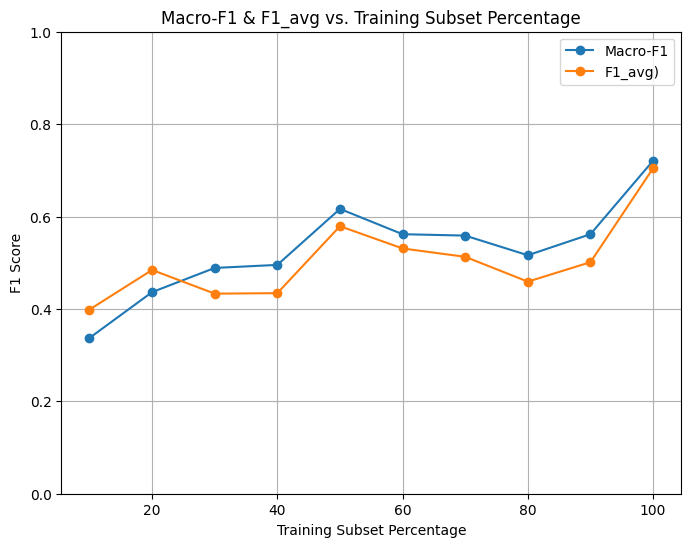

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the results

# Load the CSV file
csv_path = "/content/drive/MyDrive/comps artifact/btweet_finetuning_summary2.csv"
plot_df = pd.read_csv(csv_path)


#plot_df["f1_against_favor"] = (plot_df["f1_label_0"] + plot_df["f1_label_1"]) / 2

# Plot fraction vs. f1_avg
plt.figure(figsize=(8,6))
plt.plot(plot_df["fraction"], plot_df["macro_f1"], marker='o', label="Macro-F1")
plt.plot(plot_df["fraction"], plot_df["f1_avg"], marker='o', label="F1_avg)")
plt.title("Macro-F1 & F1_avg vs. Training Subset Percentage")
plt.xlabel("Training Subset Percentage")
plt.ylabel("F1 Score")
plt.ylim([0,1])
plt.grid(True)
plt.legend()
plt.show()
